# Master Thesis - Simulated Pick and Place Machine

<img src="simulation_v2.png" width="750">

## Modules imported

In [25]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import pandas as pd
import numpy as np
import os
import time
import datetime

import networkx as nx
import matplotlib.pyplot as plt
from graphviz import Digraph

pd.set_option('future.no_silent_downcasting', True)

## Processflow

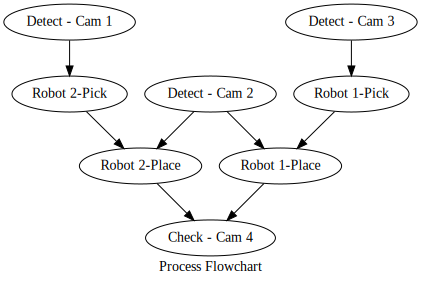

In [26]:
flow = Digraph()

# Define nodes and edges
flow.node('A', 'Detect - Cam 1')
flow.node('B', 'Detect - Cam 2')
flow.node('C', 'Detect - Cam 3')
flow.node('D', 'Robot 1-Pick')
flow.node('E', 'Robot 1-Place')
flow.node('F', 'Robot 2-Pick')
flow.node('G', 'Robot 2-Place')
flow.node('H', 'Check - Cam 4')

flow.edges(['CD', 'BE', 'DE', 'AF','BG','EH','GH','FG'])

flow.attr(label='Process Flowchart')

flow.render('flowchart', format='png', cleanup=True)

flow

### Custom functions

In [27]:
def data_process(data : pd.DataFrame):
    return data.replace(np.nan, 0).replace({True: 1, False: 0})

def data_save_raw(data : pd.DataFrame,run_number:int,timestamp):
    main_dir = 'G:\My Drive\Master Thesis\Simulation\Datasets_raw'  # main directory name
    folder_name = f'Dataset_{run_number}_{timestamp}'
    name = get_var_name(data)
    filename = f'{name}.csv'
    folder_path = os.path.join(main_dir, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    data.to_csv(os.path.join(folder_path, filename), index=False)
    return [filename,folder_path]

def data_save_all(data: pd.DataFrame,run_number:int,type:str,timestamp):
    main_dir = 'G:\My Drive\Master Thesis\Simulation\Dataset'  # main directory name
    folder_name = f'Dataset_{timestamp}'
    filename = f'data_{run_number}_{type}.csv'
    folder_path = os.path.join(main_dir, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    data.to_csv(os.path.join(folder_path, filename), index=False)
    return [filename,folder_path]

def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name[:-3]
        
def data_read_save(files):
    camera_1 = pd.read_csv(files[0][1] + '/' + files[0][0])
    camera_1 = camera_1[['sizeX','sizeY']]
    camera_1 = camera_1.rename(columns={'sizeX': 'cam_1_X','sizeY': 'cam_1_Y'})

    camera_2 = pd.read_csv(files[1][1] + '/' + files[1][0])
    camera_2 = camera_2[['sizeX','sizeY']]
    camera_2 = camera_2.rename(columns={'sizeX': 'cam_2_X','sizeY': 'cam_2_Y'})

    data_out = pd.concat([camera_1,camera_2],axis=1)

    camera_3 = pd.read_csv(files[2][1] + '/' + files[2][0])
    camera_3 = camera_3[['sizeX','sizeY']]
    camera_3 = camera_3.rename(columns={'sizeX': 'cam_3_X','sizeY': 'cam_3_Y'})

    data_out = pd.concat([data_out,camera_3],axis=1)

    camera_EoL = pd.read_csv(files[3][1] + '/' + files[3][0])
    camera_EoL = camera_EoL[['part1SizeX','part2SizeX','part3SizeX','part4SizeX',
                             'part1SizeY','part2SizeY','part3SizeY','part4SizeY',
                             'tray1SizeX','tray1SizeY','tray2SizeX','tray2SizeY']]
    
    camera_EoL = camera_EoL.rename(columns={'part1SizeX':'EoL_3_X','part2SizeX':'EoL_4_X','part3SizeX':'EoL_5_X','part4SizeX':'EoL_6_X',
                                            'part1SizeY':'EoL_3_Y','part2SizeY':'EoL_4_Y','part3SizeY':'EoL_5_Y', 'part4SizeY':'EoL_6_Y',
                                            'tray1SizeX':'EoL_1_X','tray1SizeY':'EoL_1_Y',
                                            'tray2SizeX':'EoL_2_X','tray2SizeY':'EoL_2_Y'})
    
    EoL_nodes = ['EoL_1_X', 'EoL_1_Y',
             'EoL_2_X', 'EoL_2_Y',
             'EoL_3_X', 'EoL_3_Y',
             'EoL_4_X', 'EoL_4_Y',
             'EoL_5_X','EoL_5_Y',
             'EoL_6_X', 'EoL_6_Y']
    
    scores = []

    for index, row in camera_EoL.iterrows():
        non_zero_count = (row != 0).sum()
        total_count = len(EoL_nodes)
        score = (non_zero_count / total_count) * 100
        scores.append(score)

    camera_EoL['score'] = scores

    data_out = pd.concat([data_out,camera_EoL],axis=1)

    conveyor_1 = pd.read_csv(files[4][1] + '/' + files[4][0])
    conveyor_1 = conveyor_1[['speed']]
    conveyor_1 = conveyor_1.rename(columns={'speed':'con_1'})

    data_out = pd.concat([data_out,conveyor_1],axis=1)

    conveyor_2 = pd.read_csv(files[5][1] + '/' + files[5][0])
    conveyor_2 = conveyor_2[['speed']]
    conveyor_2 = conveyor_2.rename(columns={'speed':'con_2'})

    data_out = pd.concat([data_out,conveyor_2],axis=1)

    conveyor_3 = pd.read_csv(files[6][1] + '/' + files[6][0])
    conveyor_3 = conveyor_3[['speed']]
    conveyor_3 = conveyor_3.rename(columns={'speed':'con_3'})

    data_out = pd.concat([data_out,conveyor_3],axis=1)

    rob_1 = pd.read_csv(files[7][1] + '/' + files[7][0])
    rob_1 = rob_1[['jointVelo1','jointVelo2', 'jointVelo4',	'maxVel','gripperPower','jointVelo3']]
    rob_1 = rob_1.rename(columns={'jointVelo1':'rob_1_1','jointVelo2':'rob_1_2','jointVelo3':'rob_1_3','jointVelo4':'rob_1_4',
                                  'maxVel':'rob_1_maxVel','gripperPower':'rob_1_gripper'})
    
    data_out = pd.concat([data_out,rob_1],axis=1)
    
    rob_2 = pd.read_csv(files[8][1] + '/' + files[8][0])
    rob_2 = rob_2[['jointVelo1','jointVelo2', 'jointVelo4',	'maxVel','gripperPower','jointVelo3']]
    rob_2 = rob_2.rename(columns={'jointVelo1':'rob_2_1','jointVelo2':'rob_2_2','jointVelo3':'rob_2_3','jointVelo4':'rob_2_4',
                                  'maxVel':'rob_2_maxVel','gripperPower':'rob_2_gripper'})
    
    data_out = pd.concat([data_out,rob_2],axis=1)

    return data_out
    

## Connection to Simulation

In [28]:
client = RemoteAPIClient()

sim = client.require('sim')
simBWF = client.require('simBWF')

inter_script = sim.getObject('/Interventions')

camera_1 = sim.getObject('/camera_1/camera')
camera_2 = sim.getObject('/camera_2/camera')
camera_3 = sim.getObject('/camera_3/camera')
camera_EoL = sim.getObject('/camera_EoL/camera')

conveyor1 = sim.getObject('/genericConveyorTypeA[0]')
conveyor2 = sim.getObject('/genericConveyorTypeA[2]')
conveyor3 = sim.getObject('/genericConveyorTypeA[1]')

rob_1 = sim.getObject('/Ragnar[0]')
rob_2 = sim.getObject('/Ragnar[1]')


### Setup: Simulation, runs and interventions

In [29]:
inter = {'gripper_1':'interGripper1',
         'gripper_2':'interGripper2',
         'max_Vel_1':'interVeloRob1',
         'max_Vel_2':'interVeloRob2',
         'camera_1':'interCamera1',
         'camera_2':'interCamera2',
         'camera_3':'interCamera3',
         'conveyor_1':'interConveyor1',
         'conveyor_2':'interConveyor2',
         'conveyor_3':'interConveyor3'}

run_1 ={'type':'normal'}
run_2 ={'type':'gripper_1'}
run_3 ={'type':'gripper_2'}
run_4 ={'type':'camera_1'}
run_5 ={'type':'camera_2'}
run_6 ={'type':'camera_3'}
#run_7 ={'type':'conveyor_1'}
#run_8 ={'type':'conveyor_3'}

#run_1,run_2,run_3,run_4,run_5,run_6,

simulation = [run_1]

duration = 35


### Simulation

In [30]:
run_count = 0

#Timestamp of each simulation
now = datetime.datetime.now()
timestamp = now.strftime('%Y-%m-%d_%H-%M-%S')

for run in simulation:
    
    camera_1_df = pd.DataFrame()
    camera_2_df = pd.DataFrame()
    camera_3_df = pd.DataFrame()
    camera_EoL_df = pd.DataFrame()

    conveyor_1_df = pd.DataFrame()
    conveyor_2_df = pd.DataFrame()
    conveyor_3_df = pd.DataFrame()

    rob_1_df = pd.DataFrame()
    rob_2_df = pd.DataFrame()

    for type,value in run.items():
        run_count+=1

        if value != 'normal':
            sim.callScriptFunction(inter[value],sim.getScript(sim.scripttype_customizationscript, inter_script))

        print(value)

        sim.setStepping(True)
        sim.startSimulation()

        sim.setBoolParam(sim.boolparam_display_enabled, False)

        while (t := sim.getSimulationTime()) < duration  : # 1000 took roughly 1 hour, but crashed at 795, only 15900 datapoints
            
            # Retrieve data from simulation by accessing the customData-Tables formatted in CoppeliaSim
            camera_1_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(camera_1,'customData'))])
            camera_2_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(camera_2,'customData'))])
            camera_3_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(camera_3,'customData'))])
            camera_EoL_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(camera_EoL,'customData'))])

            conveyor_1_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(conveyor1, 'customData'))])
            conveyor_2_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(conveyor2, 'customData'))])
            conveyor_3_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(conveyor3, 'customData'))])

            rob_1_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(rob_1,'customData'))])
            rob_2_data = pd.DataFrame([sim.unpackTable(sim.readCustomDataBlock(rob_2,'customData'))])
            
            # Fill dataframes
            camera_1_df= pd.concat([camera_1_df,camera_1_data], ignore_index=True)
            camera_2_df= pd.concat([camera_2_df,camera_2_data], ignore_index=True)
            camera_3_df= pd.concat([camera_3_df,camera_3_data], ignore_index=True)
            camera_EoL_df= pd.concat([camera_EoL_df,camera_EoL_data], ignore_index=True)

            conveyor_1_df= pd.concat([conveyor_1_df,conveyor_1_data], ignore_index=True)
            conveyor_2_df= pd.concat([conveyor_2_df,conveyor_2_data], ignore_index=True)
            conveyor_3_df= pd.concat([conveyor_3_df,conveyor_3_data], ignore_index=True)

            rob_1_df = pd.concat([rob_1_df,rob_1_data], ignore_index=True)
            rob_2_df = pd.concat([rob_2_df,rob_2_data], ignore_index=True)

            sim.step()

        sim.stopSimulation()

        # Data processing - True,False and NaN
        camera_1_df = data_process(camera_1_df)
        camera_2_df = data_process(camera_2_df)
        camera_3_df = data_process(camera_3_df)
        camera_EoL_df = data_process(camera_EoL_df)

        conveyor_1_df = data_process(conveyor_1_df)
        conveyor_2_df = data_process(conveyor_2_df)
        conveyor_3_df = data_process(conveyor_3_df)

        rob_1_df = data_process(rob_1_df)
        rob_2_df = data_process(rob_2_df)

        # Save all files
        files = [
                    data_save_raw(camera_1_df, run_count,timestamp),
                    data_save_raw(camera_2_df, run_count,timestamp),
                    data_save_raw(camera_3_df, run_count,timestamp),
                    data_save_raw(camera_EoL_df, run_count,timestamp),
                    data_save_raw(conveyor_1_df, run_count,timestamp),
                    data_save_raw(conveyor_2_df, run_count,timestamp),
                    data_save_raw(conveyor_3_df, run_count,timestamp),
                    data_save_raw(rob_1_df, run_count,timestamp),
                    data_save_raw(rob_2_df, run_count,timestamp)
                ]
        
        data_out = data_read_save(files)
        data = data_save_all(data_out,run_count,value,timestamp)
        
        # Some time for the simulation to stop
        time.sleep(2)

normal
